In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Steepest descent

Consider the following fixed point iteration for minimizing a given function $f : \mathbb{R}^n \rightarrow \mathbb{R}$
$$
u^{(k+1)} = u^{(k)} - \alpha \nabla f(u^{(k)}),
$$
where $f$ is twice continuously differentiable and strictly convex:
$$
\mu I \preceq \nabla^2 f(u) \preceq L I,
$$
with $0 < \mu < L < \infty$.


* Show that the fixed point iteration converges linearly for $0 < \alpha < 2/L$.
* Determine the value of $\alpha$ for which the iteration converges fastest.

* [Linear convergence](https://en.wikipedia.org/wiki/Rate_of_convergence#Basic_definition) implies that $\exists 0 < \rho < 1$ such that
$$\|u^{(k+1)} - u^*\| \leq \rho \|u^{(k)} - u*\|,$$
where $u^*$. To show this we start from the iteration and substract the fixed-point and use that $\nabla f(u^*) = 0$ to get
$$(u^{(k+1)} - u^*) = (u^{(k)} - u^*) - \alpha (\nabla f(u^{(k)}) - \nabla f (u^*)).$$
Next use Taylor to express
$$\nabla f(u^{(k)}) - \nabla f (u^*) = \nabla^2 f(\eta^{(k)}) (u^{(k)} - u^*),$$
with $\eta^{(k)} = t u^{(k)} + (1-t)u^*$ for some $t \in [0,1]$. We then get
$$\|u^{(k+1)} - u^*\|_2 \leq \|I - \alpha \nabla^2 f(\eta^{(k)})\|_2 \|u^{(k)} - u^*\|_2.$$
For linear convergence we need $\|I - \alpha \nabla^2 f(\eta^{(k)})\|_2 < 1$. We use that $\|A\|_2 = \sigma_{\max}(A)$. (cf. [Matrix norms](https://en.wikipedia.org/wiki/Matrix_norm#Special_cases))
Since the eigenvalues of $\nabla^2 f$ are bounded by $L$ we need $0 < \alpha < 2/L$ to ensure this.

* The smaller the bound on the constant $\rho$, the faster the convergence. We have 
$$\|I - \alpha \nabla^2 f(\eta^{(k)})\|_2 = \ \max (|1 - \alpha \mu|, |1 - \alpha L|).$$
We obtain the smalles possible value by making both terms equal, for which we need
$$(1 - \alpha \mu) = -(1 - \alpha L),$$
this gives us an optimal value of $\alpha = 2/(\mu + L)$.

## Rosenbrock

We are going to test various optimization methods on the Rosenbrock function
$$
f(x,y) = (a - x)^2 + b(y - x^2)^2,
$$
with $a = 1$ and $b = 100$. The function has a global minimum at $(a, a^2)$.


* Write a function to compute the Rosenbrock function, its gradient and the Hessian for given input $(x,y)$. Visualize the function on $[-3,3]^2$ and indicate the neighborhood around the minimum where $f$ is convex.

* Implement the method from exercise 1 and test convergence from various initial points. Does the method always convergce? How small do you need to pick $\alpha$? How fast?

* Implement a linesearch strategy to ensure that $\alpha_k$ satisfies the Wolfe conditions, does $\alpha$ vary a lot?

In [126]:
def rosenbrock(x,a=1,b=100):
    x1 = x[0]
    x2 = x[1]
    f = (a - x1)**2 + b*(x2 - x1**2)**2
    g = np.array([-2*(a - x1) - 4*x1*b*(x2 - x1**2), 2*b*(x2 - x1**2)])
    H = np.array([[12*b*x1**2 -4*b*x2 + 2, -4*x1*b],[-4*b*x1, 2*b]])
    return f,g,H

In [127]:
def steep(f,x0,alpha,niter):
    n = len(x0)
    x = np.zeros((niter,n))
    x[0] = x0
    for k in range(niter-1):
        fk,gk,_ = f(x[k])
        x[k+1] = x[k] - alpha*gk
    return x

Below we see a graph of the function

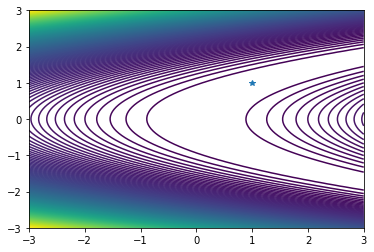

In [128]:
n = 100
x1 = np.linspace(-3,3,n)
x2 = np.linspace(-3,3,n)
xx1,xx2 = np.meshgrid(x1,x2)

xs = np.array([1,1])
fs = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        fs[i,j],_,_ = rosenbrock((x1[i],x2[j]))
plt.contour(xx1,xx2,fs,levels=200)
plt.plot(xs[0],xs[1],'*')

To determine the region around the minimum for which the function is convex we consider the eigenvalues of the Hessian (should be positive).

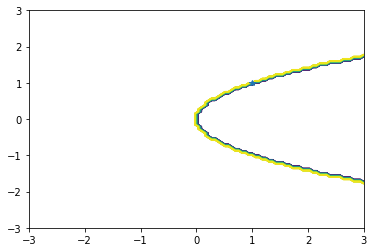

In [130]:
e1 = np.zeros((n,n))
e2 = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        _,_,Hs = rosenbrock((x1[i],x2[j]))
        e1[i,j],e2[i,j] = np.linalg.eigvals(Hs)
plt.contour(xx1,xx2,(e1>0)*(e2>0),levels=50)
plt.plot(xs[0],xs[1],'*')

To determine the optimal $\alpha$, look at the eigenvalues we computed previously. We find $L = 12122$, $\mu = 0$ and use $\alpha = 1.99/L$. We expect a convergence factor of $\rho = (1 - \alpha/L)$.

In [223]:
L = 12122
alpha = 1.99/L

In [224]:
x = steep(rosenbrock, [3,-3],alpha,50000)

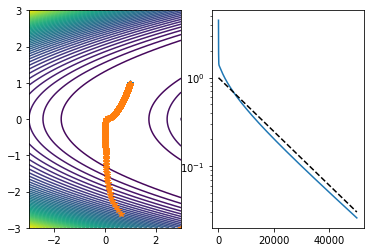

In [225]:
k = np.linspace(1,50000,50000)
fig,ax = plt.subplots(1,2)
ax[0].contour(xx1,xx2,fs,levels=50)
ax[0].plot(1,1,'*')
ax[0].plot(x[:,0],x[:,1],'*')
ax[1].semilogy(k,np.linalg.norm(x - xs,axis=1),k,(.99993)**k,'k--')

We note that we need a lot of iterations, but do converge from any starting point. Convergence is linear as can be seen by fitting a straight line through the log plot. The rate is quicker than expected from the bounds. This makes sense because the bounds are attained at the boundaries, not near the minimum.

To implement the linesearch we are going to cheat and use the [SciPy version](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.optimize.line_search.html)

In [184]:
from scipy.optimize import line_search

In [226]:
def steep_wolfe(f,x0,alpha0,niter):
    n = len(x0)
    x = np.zeros((niter,n))
    x[0] = x0
    for k in range(niter-1):
        fk,gk,_ = f(x[k])
        pk = -alpha0*gk #reference stepsize
        alpha = line_search(lambda x : rosenbrock(x)[0], lambda x : rosenbrock(x)[1], x[k], pk)[0]
        if alpha: # check if linesearch was successfull
            x[k+1] = x[k] + alpha*pk
        else: # if not, use regular step
            x[k+1] = x[k] + pk
    return x

In [227]:
x = steep_wolfe(rosenbrock, [3,-3],1.99/L,50000)

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


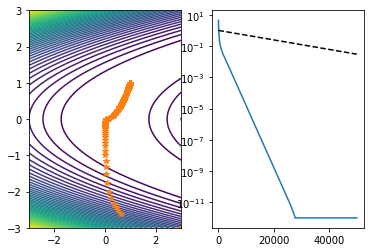

In [228]:
k = np.linspace(1,50000,50000)
fig,ax = plt.subplots(1,2)
ax[0].contour(xx1,xx2,fs,levels=50)
ax[0].plot(1,1,'*')
ax[0].plot(x[:,0],x[:,1],'*')
ax[1].semilogy(k,np.linalg.norm(x - xs,axis=1),k,(.99993)**k,'k--')

We note that the linesearch gives much faster convergence by taking larger steps whenever possible.